In [1]:
import os
from functools import lru_cache
import copy
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy.sparse as sp
from scipy.sparse import csr_matrix, diags
from scipy.linalg import lu_factor, lu_solve, solve
#from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset


In [2]:

def unitcell(w, d, t, e, m):
    dim = 2 * m

    base_val = (w + 1j*d)

    base = base_val * np.eye(2*m)

    idy = np.arange(0,2*m-1,1)

    base[idy,idy+1] = t
    base[idy+1,idy] = t

    idx = np.arange(0,m,2)

    base[idx,2*m-1-idx] = t
    base[2*m-1-idx,idx] = t

    return base 


def connection(t,m):
    idx = np.arange(2,m,2)
    base = np.zeros((2*m,2*m),dtype=np.complex64)

    base[2*m - idx,idx - 1] = t 

    return base



def T1_matrix(t, m):
    dim = 2 * m
    T = np.zeros((dim, dim), dtype=np.complex128)

    n = np.arange(1, (m - 1)//2 + 1)
    i = 2*n - 1           # to 0-based
    j = 2*m - 2*n

    T[i, j] = t
    return T


In [3]:
# ----------------------------------------------------------------------
# 1) Precomputed global cache of device_combs per width
# ----------------------------------------------------------------------
DEVICE_COMBS = {}


def _get_device_combs(width: int) -> np.ndarray:
    """
    Return (global cached) device combinations for a given width.
    Each row is (i, j) with i in [0..99] and j in [0..width-1].
    """
    width = int(2*width)
    if width not in DEVICE_COMBS:
        # Build once, store once
        DEVICE_COMBS[width] = np.stack(
            np.meshgrid(np.arange(100), np.arange(width), indexing="ij"),
            axis=-1
        ).reshape(-1, 2)
    return DEVICE_COMBS[width]


# ----------------------------------------------------------------------
# 2) Cached selection of N random impurity sites for a given config
# ----------------------------------------------------------------------
@lru_cache(maxsize=2048)
def chosen_for_config(n: int, width: int, config: int) -> np.ndarray:
    """
    Return n rows selected deterministically by given config.
    Completely cached.
    """
    n = int(n)
    width = int(width)
    config = int(config)

    device_combs = _get_device_combs(width)

    rng = np.random.RandomState(config)
    idx = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[idx]


# ----------------------------------------------------------------------
# 3) Factory: returns function(seed) → chosen impurity rows
# ----------------------------------------------------------------------
def possible_combs(n: int, width: int):
    n = int(n)
    width = int(width)

    def combs_for_seed(seed: int):
        return chosen_for_config(n, width, seed)

    return combs_for_seed


# ----------------------------------------------------------------------
# 4) Device builder
# ----------------------------------------------------------------------
def unidevice(w, d, t, e, size, config, n, numberofunitcell, combs_fn=None):
    """
    Build a device Hamiltonian unit with impurities inserted at positions
    determined by 'config'. Uses vectorised assignments where possible.
    """

    size = int(size)

    
    if combs_fn is None:
        combs_fn = possible_combs(int(n), int(size))

    # Chosen impurity coordinates
    imps = combs_fn(int(config))
    x = imps[:, 0]
    y = imps[:, 1]

    z = int(numberofunitcell)

    # Base Hamiltonian (already cached inside your unitcell_leads)
    mat = unitcell(w, d, t, e, int(size))

    # Identify impurities in unitcell z
    mask = (x == z)
    if not np.any(mask):
        return mat  # fast path return

    imp_indices = y[mask]

    # Vectorised diagonal modification
    diag_val = (w + 1j*d - 0.5)
    mat[imp_indices, imp_indices] = diag_val

    return mat


In [4]:
possible_combs(5, 7)(10001)

array([[40,  0],
       [11, 13],
       [23,  3],
       [31, 10],
       [10,  0]])

In [5]:
leads_path = os.getcwd()
print(leads_path)

/home/shardul/machine_learning/transmission_github/transmissions/notebooks


In [6]:
g_7 = np.load(
    os.path.expanduser('~/machine_learning/transmission_github/transmissions/leads/agnr_7.npy')
)


In [7]:
def device_transmission(w, d, t, e,size,config,concentration):
    ene = int(w*100)



    m = size    


    left = g_7[ene]     # left lead surface Green's function
    right = g_7[ene]     # right lead

    T  = connection(t,m)

    I = np.eye(2*m, dtype=complex)
    Td = T.conj().T
    

    tin =  T1_matrix(t, m)

    tin_d = tin.T


    combs_fn = possible_combs(concentration,size)

    g_new = left


    for i in range(100):
        
        unit = unidevice(w, d, t, e, size, config, concentration, i, combs_fn=combs_fn)
#        print(unit.shape)
        gd = np.linalg.inv(unit)

        G = np.linalg.solve(I - gd @ tin_d @ g_new @ tin, gd)

        g_new = G


    left_device = g_new

    IL = np.linalg.solve(I - left_device @ Td @ right @ Td, left_device)
    IR = np.linalg.solve(I - right @ Td @ left_device @ Td, right)
    gdd = IL - IL.conj().T
    grr = IR - IR.conj().T

    Gnonlocal = right @ Td @ IL
    GNON = Gnonlocal - Gnonlocal.conj().T

    term1 = gdd @ T @ grr @ Td
    term2 = T @ GNON @ Td @ GNON

    tr1 = np.abs(np.trace(term1 - term2))

    return tr1


In [8]:
pristine = np.array([device_transmission(w,0.0001,1,0,7,0,0) for w in np.arange(0,3,0.01)])

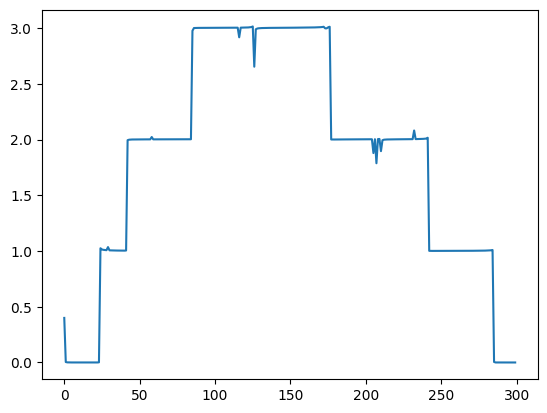

In [9]:
plt.plot(pristine)

In [10]:
file_path = os.path.expanduser("~/machine_learning/transmission_github/transmissions/data/raw/transmission_results/")

In [11]:
@lru_cache(1028)
def ca(conc):
    df = []
    d1 = [np.clip(np.load(os.path.join(file_path + f'7_agnr_conc{conc}_cfg{config}.npy')), 0, pristine) for config in range(10000)]
    df.append(d1)

    return np.mean(df, axis=1)



In [15]:
input_1 = np.array([device_transmission(w,0.0001,1,0,7,15,10) for w in np.arange(0,3,0.01)])

In [12]:
data_test = {}
configs =  np.arange(10001,10100,1)
conc = np.arange(5,50,3)

for con in conc:
    print(f"working on {con}")
    data_test[con] = [[device_transmission(w,0.0001,1,0,7,conf,con) for w in np.arange(0,3,0.01)] for conf in configs]

working on 5
working on 8
working on 11
working on 14
working on 17
working on 20
working on 23
working on 26
working on 29
working on 32
working on 35
working on 38
working on 41
working on 44
working on 47


In [13]:
def misfit(input):

    input = np.array(input)

    mis_1 = [np.sum((np.abs(input - ca(con)[0])[:190])**2)/190 for con in np.arange(1,50,2)]

    concs = np.arange(1,50,2)


    minimas = np.min(mis_1)

    return  minimas

In [16]:
misfit(input_1)

np.float64(10.392997290118508)

In [ ]:
con_err = []
for c in np.arange(1,50,3):
    mis, min = misfit(c)
    
#    print(np.array(min).reshape(-1))
    err = np.sum(np.abs((np.array(min).reshape(-1)) - c)/c)/100
    con_err.append(err)

    print(f"Error for concentration {c} is : ====>>>> {err}")

    

In [14]:
@lru_cache(maxsize=1024)
def impurity_distance_matrix(conc,size, config):
    imps  = possible_combs(conc, size)
    item = imps(config)
    #print(np.diag(item[:,1]))
    x = np.stack((size - item[:,1],item[:,1]), axis=1)
    return squareform(pdist(item, metric='euclidean')) + np.diag(x.min(axis=1))

In [17]:
print("Creating manifest file...")

# This will store the info for each s#ample
manifest_data = []
# Define the root directory where files are stored
root_dir = os.path.expanduser(
    '~/machine_learning/transmission_github/transmissions/data/raw/transmission_results'
)

# Use the same loops as your original script
for conc in np.arange(1, 50, 2):
    for config in range(10000):
        # We just construct the path, we don't load the file here
        path = f'7_agnr_conc{conc}_cfg{config}.npy'
        full_path = os.path.join(root_dir, path)

        # Check if the file actually exists before adding it to the manifest
        if os.path.exists(full_path):
            manifest_data.append({
                "concentration": conc,
                "config_id": config,
                "filepath": path  # Store the relative path
            })

# Convert the list of data into a pandas DataFrame
manifest_df = pd.DataFrame(manifest_data)

# Save the manifest to a CSV file
manifest_df.to_csv("manifest_agnr.csv", index_label="id")

print(f"Done! Created manifest.csv with {len(manifest_df)} entries.")

Creating manifest file...
Done! Created manifest.csv with 250000 entries.


In [18]:
class transmissions_dataset(Dataset):
    def __init__(self, manifest_file, root_dir, matrix_size=50):
        self.manifest = pd.read_csv(manifest_file, index_col="id")
        self.root_dir = root_dir
        self.matrix_size = matrix_size
        
        if pristine is None:
            raise ValueError("You must pass pristine array when creating the dataset.")
        self.pristine = np.asarray(pristine)

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        sample_info = self.manifest.iloc[idx]

        conc   = int(sample_info["concentration"])
        config = int(sample_info["config_id"])
        size   = self.matrix_size   # <= used for distance matrix

        # ----------------------------------------------------
        # 1) Load and process transmission
        # ----------------------------------------------------
        filepath = os.path.join(self.root_dir, sample_info["filepath"])
        transmission = np.load(filepath)

        trans = transmission
        pris  = self.pristine
        trans = np.clip(trans, 0, pris)

        x = torch.tensor(trans, dtype=torch.float32)

        # ----------------------------------------------------
        # 2) Distance matrix from impurities (FAST version)
        # ----------------------------------------------------
        # Call signature: (conc, size, config)
        dist_small = impurity_distance_matrix(conc, size, config)

        # zero-pad
        dist_mat = np.zeros((size, size))
        dist_mat[:conc, :conc] = dist_small

        D = torch.tensor(dist_mat, dtype=torch.float32)

        # ----------------------------------------------------
        # 3) Label = concentration
        # ----------------------------------------------------
        y = torch.tensor([conc], dtype=torch.float32)

        # ----------------------------------------------------
        # Return without D if you're not training with it yet
        # ----------------------------------------------------
        return x, y
        # return x, y, D   # uncomment when training with D


In [19]:
dataset = transmissions_dataset(manifest_file='manifest_agnr.csv', root_dir=os.path.expanduser('~/machine_learning/transmission_github/transmissions/data/raw/transmission_results'))

In [20]:
class TestingDataset(Dataset):
    def __init__(self, data_test, pristine):
        """
        data_test: dict[conc] -> list[config_idx] -> list[w] (transmission values)
        pristine: 1D np.array of same length as each transmission curve (e.g. 300)
        """
        self.data_test = data_test
        self.pristine  = np.asarray(pristine)

        # Build index map: flatten (conc, config_idx) pairs
        self.index_map = []
        for conc in sorted(data_test.keys()):
            num_configs = len(data_test[conc])
            for config_idx in range(num_configs):
                self.index_map.append((conc, config_idx))

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        conc, config_idx = self.index_map[idx]

        # transmission curve: list over w
        trans = np.asarray(self.data_test[conc][config_idx], dtype=np.float32)

        # clip against pristine
        trans = np.clip(trans, 0, self.pristine)

        x = torch.tensor(trans, dtype=torch.float32)         # shape [300] (or whatever length)
        y = torch.tensor([conc], dtype=torch.float32)        # label is the concentration

        return x, y


In [22]:
len(TestingDataset(data_test, pristine))

1485

In [23]:
class Conductance_Inversion_CNN(nn.Module):
    def __init__(self, input_length=200, final_hidden_dim=64):
        super().__init__()
        
        # 1. Feature Extraction (1D CNN layers)
        # Input shape: [Batch, 1, 200]
        self.conv_features = nn.Sequential(
            # Layer 1: Detect basic features (width 5)
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Output size: 100
#            nn.Dropout(0.3),

            # Layer 2: Detect complex/aggregated features
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Output size: 50
#            nn.Dropout(0.3),
            
            # Layer 3: Deeper feature aggregation
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3),
            
            # Layer 3: Deeper feature aggregation
            nn.Conv1d(in_channels=32, out_channels=final_hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3)

        )
        
        # 2. Global Aggregationx
        # Condenses all features into a single, fixed-size vector
        self.aggregator = nn.AdaptiveAvgPool1d(1)
        
        # 3. Regression Head (Fully Connected layers)
        # Maps the extracted features to the scalar output 'n'
        self.regressor = nn.Sequential(
            nn.Linear(final_hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1) # Output: Concentration 'n' (scalar)
        )

    def forward(self, x):
        # x must be reshaped for Conv1D: [Batch, Length] -> [Batch, 1, Length]
        x = x.unsqueeze(1)
        
        # Feature Extraction
        x = self.conv_features(x)
        
        # Aggregation: Resulting size is [Batch, final_hidden_dim, 1]
        x = self.aggregator(x)
        
        # Flatten and Regression: [Batch, final_hidden_dim]
        x = x.squeeze(-1) 
        
        return self.regressor(x)

In [25]:
def training_model(num_epochs, val_split):
    # 1. GPU Support
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    model = Conductance_Inversion_CNN(input_length=200, final_hidden_dim=64).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Scheduler to reduce LR when loss stops dropping
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3
#        verbose=True###
    )

    # Split Data
    n_val = int(len(dataset) * val_split)
    n_train = len(dataset) - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, shuffle=True, batch_size=32)
    val_loader   = DataLoader(val_ds, shuffle=False, batch_size=32)

    train_loss_history = []
    val_loss_history   = []
    
    # Track the best model
    best_val_loss = float('inf')
    best_model_weights = None

    for epoch in range(num_epochs):
        # -----------------------
        #      TRAINING
        # -----------------------
        model.train()
        running_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)        # [batch, 200]
            yb = yb.to(device)        # [batch]

            # Forward pass
            preds = model(xb).squeeze(-1)   # [batch]
            yb = yb.squeeze(-1)

            
            misfit_term = torch.tensor([misfit(x.detach().cpu().numpy()) for x in xb], dtype=torch.float32,device=device).mean()

                     
            loss  = F.mse_loss(preds, yb) + misfit_term

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train = running_loss / len(train_loader)
        train_loss_history.append(avg_train)

        # -----------------------
        #     VALIDATION
        # -----------------------
        model.eval()
        running_val = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                preds = model(xb).squeeze(-1)
                yb = yb.squeeze(-1)
                misfit_term = torch.tensor([misfit(x.detach().cpu().numpy()) for x in xb], dtype=torch.float32,device=device).mean()
                loss  = F.mse_loss(preds, yb) + misfit_term

                running_val += loss.item()

        avg_val = running_val / len(val_loader)
        val_loss_history.append(avg_val)
        
        # -----------------------
        # UPDATES & CHECKPOINTING
        # -----------------------
        
        # 1. Update Scheduler (Crucial step that was missing!)
        scheduler.step(avg_val)

        # 2. Save Best Model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            # Deep copy the weights so they don't get overwritten in next epoch
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch+1:03d} | Train: {avg_train:.4f} | Val: {avg_val:.4f} * Saved Best")
        else:
            print(f"Epoch {epoch+1:03d} | Train: {avg_train:.4f} | Val: {avg_val:.4f}")

    # -----------------------
    #     FINALIZE
    # -----------------------
    
    # Load the best weights back into the model before returning
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nTraining Complete. Loaded best model with Val Loss: {best_val_loss:.4f}")

    # PLOT LOSSES
    plt.figure(figsize=(10,6))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    
    # Mark the best epoch on the plot
    best_epoch_idx = val_loss_history.index(best_val_loss)
    plt.axvline(best_epoch_idx, color='green', linestyle='--', label='Best Model')
    
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, (train_loss_history, val_loss_history)

Training on: cpu
Epoch 001 | Train: 21.8582 | Val: 9.3528 * Saved Best
Epoch 002 | Train: 10.7016 | Val: 7.9671 * Saved Best
Epoch 003 | Train: 10.0346 | Val: 7.1292 * Saved Best
Epoch 004 | Train: 9.2965 | Val: 6.5013 * Saved Best
Epoch 005 | Train: 8.6944 | Val: 6.3789 * Saved Best
Epoch 006 | Train: 8.2646 | Val: 5.9932 * Saved Best
Epoch 007 | Train: 7.9614 | Val: 6.0072
Epoch 008 | Train: 7.7083 | Val: 5.7078 * Saved Best
Epoch 009 | Train: 7.4829 | Val: 5.7854
Epoch 010 | Train: 7.2377 | Val: 5.5769 * Saved Best
Epoch 011 | Train: 7.0251 | Val: 5.3176 * Saved Best
Epoch 012 | Train: 6.8334 | Val: 5.1621 * Saved Best
Epoch 013 | Train: 6.7560 | Val: 7.7420
Epoch 014 | Train: 6.5532 | Val: 5.1233 * Saved Best
Epoch 015 | Train: 6.4909 | Val: 5.7098
Epoch 016 | Train: 6.3808 | Val: 4.9415 * Saved Best
Epoch 017 | Train: 6.2601 | Val: 5.1273
Epoch 018 | Train: 6.2026 | Val: 5.0665
Epoch 019 | Train: 6.0905 | Val: 5.0637
Epoch 020 | Train: 6.0307 | Val: 4.8751 * Saved Best
Epoch 021 |

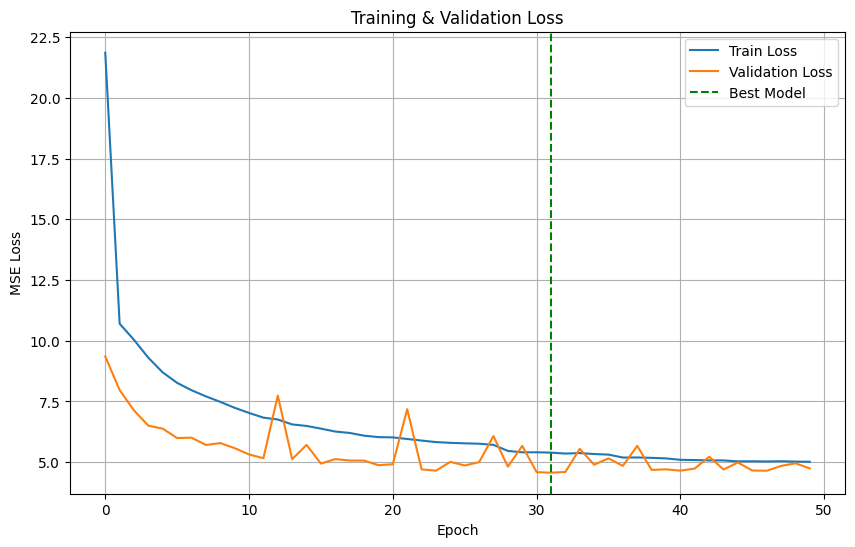

In [54]:
trained_model = training_model(50,0.2)

In [59]:
torch.save(model.state_dict(), os.path.expanduser("~/machine_learning/transmission_github/transmissions/models/trained/pinn_agnr.pth"))

In [26]:
model = Conductance_Inversion_CNN()

model.load_state_dict(torch.load(os.path.expanduser("~/machine_learning/transmission_github/transmissions/models/trained/pinn_agnr.pth")))

<All keys matched successfully>

In [27]:
def test_model_with_misfit(model, test_dataset, batch_size=32):
    """
    Test model using MSE + misfit term, same as training.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb).squeeze(-1)
            yb    = yb.squeeze(-1)

            # Misfit term computed per sample, avg over batch
            misfit_term = torch.tensor(
                [misfit(x.detach().cpu().numpy()) for x in xb],
                dtype=torch.float32,
                device=device
            ).mean()

            loss = F.mse_loss(preds, yb) #+ misfit_term
            total_loss += loss.item()

            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = total_loss / len(test_loader)
    print(f"\nTest Loss (MSE + misfit): {avg_loss:.4f}")

    return all_preds, all_labels, avg_loss


In [28]:
# 1. Build pristine reference (same length as transmission, e.g. 300 or 200)
# pristine = ...  # must exist already; you were using it in training

# 2. Create test dataset
test_dataset = TestingDataset(data_test, pristine)

# 3. Call testing
preds, labels, test_loss = test_model_with_misfit(model, test_dataset, batch_size=32)

# 4. Inspect the first few predictions
for i in range(10):
    print(f"Sample {i:02d} | True conc: {labels[i]:.1f} | Pred: {preds[i]:.2f}")



Test Loss (MSE + misfit): 4.1843
Sample 00 | True conc: 5.0 | Pred: 4.23
Sample 01 | True conc: 5.0 | Pred: 6.66
Sample 02 | True conc: 5.0 | Pred: 6.13
Sample 03 | True conc: 5.0 | Pred: 4.76
Sample 04 | True conc: 5.0 | Pred: 5.42
Sample 05 | True conc: 5.0 | Pred: 5.27
Sample 06 | True conc: 5.0 | Pred: 6.62
Sample 07 | True conc: 5.0 | Pred: 4.44
Sample 08 | True conc: 5.0 | Pred: 5.52
Sample 09 | True conc: 5.0 | Pred: 4.60


In [29]:
labels

array([ 5.,  5.,  5., ..., 47., 47., 47.], shape=(1485,), dtype=float32)

In [30]:
results = pd.DataFrame()

In [31]:
results['labels']  = labels
results['predictions'] = preds

results['error'] = abs(preds-labels)

In [ ]:
results

,labels,predictions,error
0,5.0,4.232852,0.767148
1,5.0,6.659317,1.659317
2,5.0,6.133420,1.133420
3,5.0,4.760619,0.239381
4,5.0,5.416949,0.416949
...,...,...,...
1480,47.0,46.593056,0.406944
1481,47.0,43.937172,3.062828
1482,47.0,43.078400,3.921600
1483,47.0,46.797337,0.202663
